In [134]:
#!pip install iapws

In [135]:
import iapws

import numpy as np
import seaborn as sns; sns.set_theme(style="whitegrid", palette="pastel", color_codes=True)
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

Estimate the density of water @ $1$ $atm$ e $25°C$ using:
1. Thermo properties
2. EOS

# Vapor tables

In [136]:
# initial data
T_water = 25+273.15  # Celsius p/ Kelvin
P_water = 1*101325     # Bar p/ Pa
Tc_water = 373.99+273.15    # Celsius p/ Kelvin
Pc_water = 220.64*101.325   # Bar p/ Pa
MW = 18.    # g/mol
w = 0.344   # admensional
R = 8.314   # J/mol.K

In [137]:
@np.vectorize
def from_steam_tables(temperature, pressure):
  compound_dict = iapws._iapws._Liquid(temperature,
                                      (pressure/101325)*.1)   # conversion to MPa (required on the library)
  ρ_water = compound_dict['rho']/1000
  return ρ_water

water_density=from_steam_tables(T_water, P_water)
print(f'From steam tables: Density = {np.round(water_density,2)} g/cm³')


From steam tables: Density = 1.0 g/cm³


# Rackett Correlation for Liquids

In [138]:
@np.vectorize
def from_rackett_correlation(temperature, pressure, critical_temperature, MW,
                             critical_pressure, accentric_factor, A, B, C):
  """
  Dados:
  T: [K]
  P: [Pa]
  Tc: [K]
  Pc: [Pa]
  MW: [kg/kmol]
  w: [adm]

  -----------------------
  Calcula:
  Tr: [adm]
  Volume sat. molar: [m³/mol]
  Pressão vapor: [Pa] - Antoine
  Fator compressibilidade: [adm]

  -----------------------
  Retorna:
  Densidade: [kg/m³]
  """

  Tr=temperature/critical_temperature
  β_P = -1 - 9.070217*((1-Tr)**(2/3)) + 62.45326*((1-Tr)**(2/3))- \
        135.1102*(1-Tr) + np.exp(4.79594 + 0.250047*accentric_factor + \
                                 1.14188*(accentric_factor**2)) * ((1-Tr)**(4/3))

  # units conversion
  pvap_antoine=10**(A - (B/(C+temperature)))*1e5

  Zra = 0.2956-0.08775*accentric_factor
  Vol_sat = R*(critical_temperature/critical_pressure)*((Zra)**(1+((1-Tr)**(2/7))))

  compressed_liq_vol = Vol_sat*(1-(0.0861488+0.03444836*accentric_factor)*\
                                (np.log(β_P+1)-np.log((β_P)+(pvap_antoine/pressure))))

  ρ_liq = MW/(1e3*compressed_liq_vol)
  return ρ_liq

In [139]:
ρ_liquid_rackett = from_rackett_correlation(T_water, P_water, Tc_water, MW, Pc_water,
                                      w, 5.40221, 1838.675, -31.737)

print(f'Density Rackett Method {np.round(ρ_liquid_rackett,2)} g/cm³')

Density Rackett Method 0.86 g/cm³


# Van der Walls

In [140]:
a = (27*(R*Tc_water)**2)/(64*Pc_water*1e3)  # correction factor due to molecular interactions
b = (R*Tc_water)/(8*(Pc_water*1e3))         # volume correction factor

@np.vectorize
def van_der_walls(shot) :
  return (P_water+(a/shot**2))*(shot-b)-R*T_water

init = [0.5]
sol, = fsolve(van_der_walls, init)
ρ_vdW = ((1/sol)*MW)/1e3
print(f'Density of water Van der Walls: {round(ρ_vdW,2)} kg/m³')

Density of water Van der Walls: 0.74 kg/m³


# Desvios observados

In [141]:
print(f'Racketts method deviation from steam tables: {round(100-(ρ_liquid_rackett/water_density)*100)}%')
print(f'VdW EoS deviation from steam tables: {round(100-(ρ_vdW/water_density)*100,2)}%')

Racketts method deviation from steam tables: 14%
VdW EoS deviation from steam tables: 25.62%


**Analysis**: Naturally, devations will happen.
* Results presented by steam tables are more satisfactory than the other correlations whose results were near atmospheric conditions ($1g/cm³$).
  
* Rackett's correlation presented less deviation from stream tables than VdW EoS.
  
* Rackett's correlation is extensively used for estimation of liquid phase densities, besides obtaining the molar volume in the saturation region it presents a correction factor which results in the molar volume of interest.
  
* VdW EoS also present correction terms $(a(T)$ e $b(T))$, presenting inferior performance though.

# Plotting

## Varying temperature @ P= constant.

### Using MATPLOTLIB

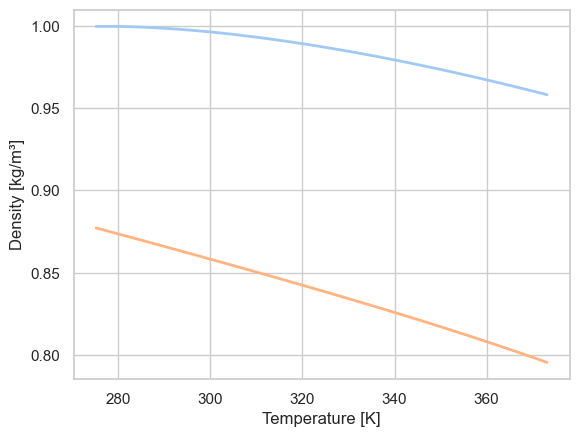

In [142]:
Temperature_variation = np.linspace(275.15, 373.15,100)
Pressure_fixed = 101325 # Pa

def plotting_comparison(f, var, *args):
    plt.plot(Temperature_variation, f(*var), lw=2.); plt.xlabel('Temperature [K]'); plt.ylabel('Density [kg/m³]')


plotting_comparison(from_steam_tables, [Temperature_variation, Pressure_fixed])
plotting_comparison(from_rackett_correlation, [Temperature_variation, Pressure_fixed,
                                               Tc_water, MW, Pc_water, w,
                                               5.40221, 1838.675, -31.737]);

### Using PLOTLY

In [143]:
import numpy as np
import plotly.graph_objs as go

T_water = 300  
P_water = 101600  
Tc_water = 647.096  
MW = 18.01528 
Pc_water = 22064000  
w = 0.344  
R = 8.314  

@np.vectorize
def from_steam_tables(temperature, pressure):
    pressure_conversion = (pressure/101325)*.1
    compound_dict = iapws._iapws._Liquid(temperature, pressure_conversion)
    ρ_water = compound_dict['rho']
    return ρ_water

def from_rackett_correlation(temperature, pressure, critical_temperature, MW,
                             critical_pressure, accentric_factor):
    Tr = temperature / critical_temperature
    β_P = -1 - 9.070217*((1-Tr)**(2/3)) + 62.45326*((1-Tr)**(2/3)) - \
        135.1102*(1-Tr) + np.exp(4.79594 + 0.250047*accentric_factor + \
                                 1.14188*(accentric_factor**2)) * ((1-Tr)**(4/3))
    pvap_antoine = 10**(8.07131 - 1730.63 / (233.426 + temperature))
    Zra = 0.2956-0.08775*accentric_factor
    Vol_sat = R*(critical_temperature/critical_pressure)*((Zra)**(1+((1-Tr)**(2/7))))
    compressed_liq_vol = Vol_sat*(1-(0.0861488+0.03444836*accentric_factor)*\
                                (np.log(β_P+1)-np.log((β_P)+(pvap_antoine/pressure))))
    ρ_liq = MW/(1e3*compressed_liq_vol)
    return ρ_liq

# Generate temperature values for from_rackett_correlation
Temperature_variation = np.linspace(275.15, 373.15, 100)

In [144]:
def plotting_comparison(pressure):
    fig = go.Figure()

    # Plot from_steam_tables
    steam_table_density = from_steam_tables(Temperature_variation, pressure)
    fig.add_trace(go.Scatter(x=Temperature_variation,
                             y=steam_table_density,
                             mode='markers',
                             name='From Steam Tables'))

    # Plot from_rackett_correlation
    rackett_density = from_rackett_correlation(Temperature_variation, pressure,
                                               Tc_water, MW, Pc_water, w)
    fig.add_trace(go.Scatter(x=Temperature_variation,
                             y=rackett_density,
                             mode='lines',
                             name='From Rackett Correlation'))

    fig.update_layout(title="Density Comparison",
                      xaxis_title="Temperature (K)",
                      yaxis_title="Density (kg/m³)")
    return fig

# Generate the initial plot
initial_plot = plotting_comparison(P_water)
initial_plot.show()

# Exemplo adicional

Given that the vapor pressure of n-butane at $350$ $K$ is $9.4573$ $bar$. Find the molar volumes of  
a. saturated-vapor  
b. saturated-liquid   
of n-butane at these conditions as
given by the Redlich/Kwong equation.

In [145]:
# dados do problema
T_sys = 350   # Kelvin
P_sys = 9.4573  # Bar
R = 83.14   # cm3 Bar/mole K

# dados a partir de Van Ness et al.
Tc_nbutane = 151.97  # Celsius
Pc_nbutane = 37.96   # Bar
omg_nbutane = 0.199  # acentric factor
MW_nbutane = 58.12   # g/mol

# cálculo do volume molar
def molar_volume(Z_real, temperature, pressure):
  v_molar = Z_real*R*temperature/pressure
  return v_molar

def density_conversion(molar_volume_function):  # there's a conversion (x1000) [g/mol -> kg/mol]
  return MW_nbutane*1000/molar_volume_function

## Soave-Redlich-Kwong

In [146]:
# fase de interesse
phase = str(input('Para qual fase calular? - (V):Vapor, (L):Líquido\n')).upper()

def compressibility_factor_SRK(Z):
  min_f = np.zeros(1)

  # 'fingerprint'
  Tr = T_sys/(Tc_nbutane+273.15)
  Pr = P_sys/Pc_nbutane

  # parametros p/ EOS em SRK
  sigma=1.; epsilon=0.; Omega=0.08664; Phi=0.42748; Zc=1/3;

  # cálculo das constantes em SRK
  β = Omega*Pr/Tr
  alpha_SRK = (1 + (0.480 + 1.574*omg_nbutane - 0.176*(omg_nbutane**2)) * (1-(Tr**0.5)))**2
  q = Phi*alpha_SRK/(Omega*Tr)

  # cálculo fator de compressibilidade
  if phase == 'V':
    min_f = 1 + β - (q*β * ((Z-β)/((Z+epsilon*β)*(Z+sigma*β)))) - Z
  else:
    min_f = β + (Z+epsilon*β) * (Z+sigma*β) * ((1+β-Z)/(q*β)) - Z
  return min_f

ic = [1.]
solution_SRK, = fsolve(compressibility_factor_SRK, ic)
print(f'V_ @ phase[{phase}] = {round(molar_volume(solution_SRK, T_sys, P_sys),2)} cm³/mol')
print(f'Calculated Z real: {solution_SRK}')

V_ @ phase[L] = 2520.38 cm³/mol
Calculated Z real: 0.8191327723693881


## Peng-Robinson

In [147]:
# fase de interesse
phase = str(input('Para qual fase calular? - (V):Vapor, (L):Líquido\n')).upper()

def compressibility_factor_PR(Z):
  min_f = np.zeros(1)

  # 'fingerprint'
  Tr = T_sys/(Tc_nbutane+273.15)
  Pr = P_sys/Pc_nbutane

  # parametros p/ EOS em PR
  sigma=1+(2**0.5); epsilon=1-(2**0.5); Omega=0.0778; Phi=0.45724; Zc=0.3074;

  # cálculo das constantes em PR
  β = Omega*Pr/Tr
  alpha_PR = (1 + (0.37464 + 1.54226*omg_nbutane - 0.26992*(omg_nbutane**2)) * (1-(Tr**0.5)))**2
  q = Phi*alpha_PR/(Omega*Tr)

  # cálculo fator de compressibilidade
  if phase == 'V':
    min_f = 1 + β - (q*β * ((Z-β)/((Z+epsilon*β)*(Z+sigma*β)))) - Z
  else:
    min_f = β + (Z+epsilon*β) * (Z+sigma*β) * ((1+β-Z)/(q*β)) - Z
  return min_f

solution_PR, = fsolve(compressibility_factor_PR, ic)
print(f'V_ @ phase[{phase}] = {round(molar_volume(solution_PR, T_sys, P_sys),2)} cm³')
print(f'Calculated Z real: {solution_PR}')

V_ @ phase[L] = 2486.51 cm³
Calculated Z real: 0.8081271109543343


## Redlich-Kwong

In [148]:
phase = str(input('Qual fase deseja calcular? - Vapor (V) ;  Liquid (L)?\n')).upper()

def compressibility_factor_RK(Z):
  min_f=np.zeros(1)

  # 'fingerprint'
  Tr = T_sys/(Tc_nbutane+273.15)
  Pr = P_sys/Pc_nbutane

  sigma=1.; epsilon=0.; Omega=0.08664; Phi=0.42748; Zc=1/3;

  β = Omega*Pr/Tr
  alpha_RK = Tr**(-0.5)
  q = Phi*alpha_RK/(Omega*Tr)

  if phase == 'V':
    min_f = 1 + β - (q*β * (Z-β)/((Z+epsilon*β)*(Z+sigma*β))) - Z
  else:
    min_f = β + (Z+epsilon*β) * (Z+sigma*β) * ((1 + β - Z)/(q*β)) - Z
  return min_f
ic = [1.]
solution_RK, = fsolve(compressibility_factor_RK, ic)
print(f'V_ @ phase [{phase}] = {round(molar_volume(solution_RK, T_sys, P_sys),2)} cm³/mol')
print(f'Calculated Z real: {solution_RK}')

V_ @ phase [L] = 2555.24 cm³/mol
Calculated Z real: 0.8304624682273095


# Plotting

### Fixed Pressure (@ P_sys cte. = 9.4573 bar)

1. Plotting molar volume

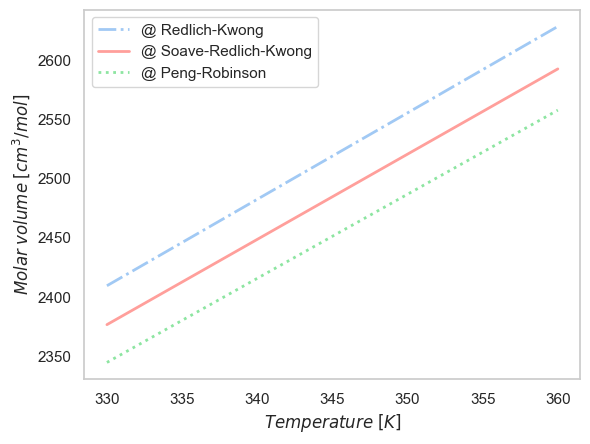

In [149]:
Temperature_sys = np.linspace(330, 360, 360)
plt.plot(Temperature_sys,molar_volume(solution_RK, Temperature_sys, P_sys), lw=2., label='@ Redlich-Kwong', color='b', ls='-.')
plt.plot(Temperature_sys,molar_volume(solution_SRK, Temperature_sys, P_sys), lw=2., label='@ Soave-Redlich-Kwong', color='r', ls='-')
plt.plot(Temperature_sys,molar_volume(solution_PR, Temperature_sys, P_sys), lw=2., label='@ Peng-Robinson', color='g', ls=':')
plt.ylabel(r'$Molar$ $volume$ $[{cm^3/mol}]$'); plt.xlabel(r'$Temperature$ $[K]$');plt.legend(loc='best');plt.grid();

2. Plotting density  
$Molar\;\;Volume\;\;[m^3/mol] = \frac{MW\;\;[kg/mol]}{ρ\;\;[kg/m^3]}$

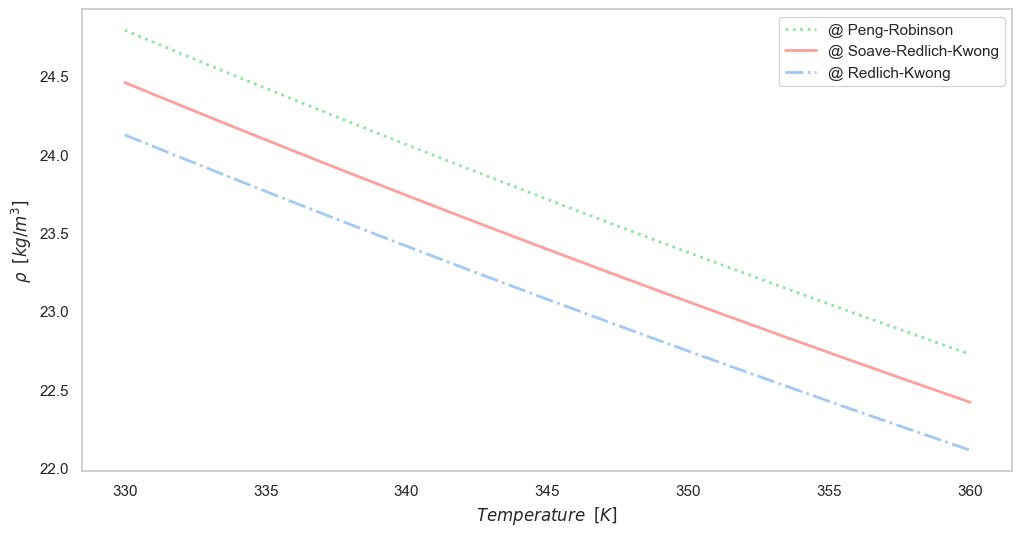

In [150]:
plt.figure(figsize=(12,6))
plt.plot(Temperature_sys, density_conversion(molar_volume(solution_PR, Temperature_sys, P_sys)), ls=':', lw=2., color='g', label='@ Peng-Robinson')
plt.plot(Temperature_sys, density_conversion(molar_volume(solution_SRK, Temperature_sys, P_sys)), ls='-', lw=2., color='r', label='@ Soave-Redlich-Kwong')
plt.plot(Temperature_sys, density_conversion(molar_volume(solution_RK, Temperature_sys, P_sys)), ls='-.', lw=2., color='b', label='@ Redlich-Kwong')
plt.ylabel(r'$ρ\;\;[kg/m^3]$');plt.xlabel(r'$Temperature\;\;[K]$');plt.legend(loc='best'); plt.grid();

$Results\;\;from\;\;Aspen$

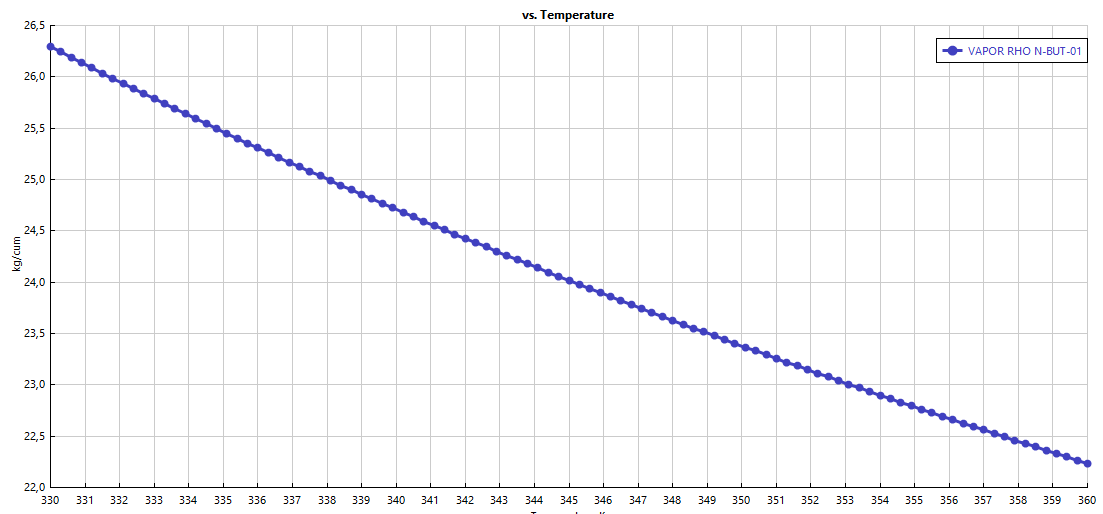

### Fixed Temperature (@ T_sys cte.)

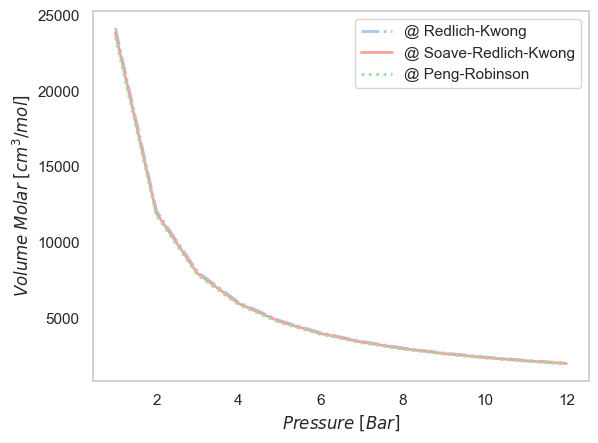

In [151]:
Pressure_sys = np.linspace(1,12,12)
plt.plot(Pressure_sys, molar_volume(solution_RK, T_sys, Pressure_sys), label='@ Redlich-Kwong', lw=2, color='b', ls='-.')
plt.plot(Pressure_sys, molar_volume(solution_SRK, T_sys, Pressure_sys),label='@ Soave-Redlich-Kwong', lw=2, color='r', ls='-')
plt.plot(Pressure_sys, molar_volume(solution_PR, T_sys, Pressure_sys),label='@ Peng-Robinson', lw=2, color='g', ls=':')
plt.ylabel(r'$Volume$ $Molar$ $[cm^3/mol]$'); plt.xlabel(r'$Pressure$ $[Bar]$'); plt.legend(loc='best'); plt.grid();